In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
excel_file = pd.read_excel('dataset_clean_Weather_semarang_float_AD.xlsx')

In [3]:
df = pd.DataFrame(excel_file)
print(df)

         Tanggal     Tn     Tx   Tavg  RH_avg         RR    ss
0     31-12-2015  260.0  316.0  287.0   800.0  91.233637  82.0
1     01-01-2016  254.0  320.0  293.0   770.0  48.116818  65.0
2     02-01-2016  262.0  316.0  281.0   860.0   5.000000  58.0
3     03-01-2016  270.0  320.0  283.0   860.0   5.222222  20.0
4     04-01-2016  232.0  323.0  278.0   840.0   5.444444  47.0
...          ...    ...    ...    ...     ...        ...   ...
2899  08-12-2023  256.0  328.0  298.0   750.0   6.000000  47.0
2900  09-12-2023  262.0  324.0  300.0   770.0   0.000000  62.0
2901  10-12-2023  260.0  316.0  285.0   820.0   0.000000  36.0
2902  11-12-2023  254.0  344.0  310.0   700.0  10.000000  10.0
2903  12-12-2023  250.0  336.0  309.0   660.0   0.000000  98.0

[2904 rows x 7 columns]


In [4]:
import numpy as np

def konversi_variabel_laju(variabel):
    jumlah_data = len(variabel)
    laju = np.zeros(jumlah_data)

    for i in range(jumlah_data):
        if i == 0:
            laju[i] = variabel[i+1] - variabel[i]
        elif 0 < i < jumlah_data - 1:
            laju[i] = ((variabel[i] - variabel[i-1]) + (variabel[i+1] - variabel[i])) / 2
        elif i == jumlah_data - 1:
            laju[i] = variabel[i] - variabel[i-1]

    return laju

In [5]:
df['laju_Tn'] = konversi_variabel_laju(df['Tn'])
df['laju_Tx'] = konversi_variabel_laju(df['Tx'])
df['laju_Tavg'] = konversi_variabel_laju(df['Tavg'])
df['laju_RH_avg'] = konversi_variabel_laju(df['RH_avg'])
df['laju_RR'] = konversi_variabel_laju(df['RR'])
df['laju_ss'] = konversi_variabel_laju(df['ss'])

In [6]:
print(df)

         Tanggal     Tn     Tx   Tavg  RH_avg         RR    ss  laju_Tn  \
0     31-12-2015  260.0  316.0  287.0   800.0  91.233637  82.0     -6.0   
1     01-01-2016  254.0  320.0  293.0   770.0  48.116818  65.0      1.0   
2     02-01-2016  262.0  316.0  281.0   860.0   5.000000  58.0      8.0   
3     03-01-2016  270.0  320.0  283.0   860.0   5.222222  20.0    -15.0   
4     04-01-2016  232.0  323.0  278.0   840.0   5.444444  47.0     -4.0   
...          ...    ...    ...    ...     ...        ...   ...      ...   
2899  08-12-2023  256.0  328.0  298.0   750.0   6.000000  47.0     -1.0   
2900  09-12-2023  262.0  324.0  300.0   770.0   0.000000  62.0      2.0   
2901  10-12-2023  260.0  316.0  285.0   820.0   0.000000  36.0     -4.0   
2902  11-12-2023  254.0  344.0  310.0   700.0  10.000000  10.0     -5.0   
2903  12-12-2023  250.0  336.0  309.0   660.0   0.000000  98.0     -4.0   

      laju_Tx  laju_Tavg  laju_RH_avg    laju_RR  laju_ss  
0         4.0        6.0        -30.0 -

In [7]:
# memisahkan fitur input dan output
input_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']
output_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']

In [8]:
# x mengambil data pada df yang fiturnya ada di input_features
# y mengambil data pada df yang fiturnya ada di output_features
x = df[input_features].values
y = df[output_features].values

In [9]:
# normalisasi supaya skalanya konsisten 0-1
# inisialisasi dulu
scaler = MinMaxScaler()

# x_scaled dan y_scaled ini adalah hasil tranformasi
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

In [10]:
# Pemisahan data uji, data latih

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, shuffle=False)
# size disini sebagai berapa banyak data yang akan kita gunakan sebagai data testing
# 0.2 artinya 20% data akan digunakan sebagai data uji dan 80% sebagai data latih
# karena kita menggunakan data time series, maka harus ditambahakan shuffle sbg mencegah terjadinya pengacakan data
# saat kita membagi data menjadi data uji dan data latih, urutannya tidak akan teracak


In [11]:
# timesteps ini adalah panjangnya rentang waktu yang akan digunakan input model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

timesteps = 4
# menggunakan data 4 hari sebelumnya menjadi input LSTM

n_features_input = len(input_features)
n_features_output = len(output_features)

In [12]:
# mendefinisikan fungsi
def create_sequences(x, y, time_steps) :
  x_seq, y_seq = [], []

# sebelum mengembalikan nilai para seq, kita akan melakukan iterasi
  for i in range(len(x)-time_steps) : #pengurangan dg timesteps krn data paling terakhir tidak akan bisa di proses
    x_seq.append(x[i : i + time_steps])
    y_seq.append(y[i + time_steps ])

  return np.array(x_seq), np.array(y_seq)

In [13]:
x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [14]:
# MODEL LSTM4
model = Sequential()

model.add(LSTM(300, input_shape=(timesteps, n_features_input), return_sequences=True))
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300))  # Layer LSTM lainnya
model.add(Dense(n_features_output))

#layer output
model.add(Dense(n_features_output))

In [15]:
model.compile(optimizer='adam', loss='mae') # mae bisa ganti rmse atau mse

In [16]:
#fitting, bangun model
hist = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=30, validation_data=(x_test_seq, y_test_seq),callbacks=[early_stopping])

Epoch 1/100

78/78 [==============================] - 39s 145ms/step - loss: 0.1680 - val_loss: 0.1205
Epoch 2/100
78/78 [==============================] - 5s 66ms/step - loss: 0.1175 - val_loss: 0.1101
Epoch 3/100
78/78 [==============================] - 5s 66ms/step - loss: 0.1096 - val_loss: 0.1054
Epoch 4/100
78/78 [==============================] - 5s 68ms/step - loss: 0.1068 - val_loss: 0.1002
Epoch 5/100
78/78 [==============================] - 5s 66ms/step - loss: 0.1030 - val_loss: 0.0978
Epoch 6/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0990 - val_loss: 0.0948
Epoch 7/100
78/78 [==============================] - 5s 65ms/step - loss: 0.0929 - val_loss: 0.0905
Epoch 8/100
78/78 [==============================] - 5s 65ms/step - loss: 0.0851 - val_loss: 0.0805
Epoch 9/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0755 - val_loss: 0.0727
Epoch 10/100
78/78 [==============================] - 5s 68ms/step - loss: 0.0703 - val_loss: 0.0

[0.1679821014404297, 0.11751815676689148, 0.10956858843564987, 0.10682622343301773, 0.10299735516309738, 0.09903645515441895, 0.09294328838586807, 0.08513928204774857, 0.07551395148038864, 0.0703492984175682, 0.0639900341629982, 0.0601411834359169, 0.056888554245233536, 0.05570387840270996, 0.05497650057077408, 0.05370952561497688, 0.052874308079481125, 0.0519813597202301, 0.05273132771253586, 0.0513119250535965, 0.05134148523211479, 0.050994206219911575, 0.04954526200890541, 0.0476476214826107, 0.04729336127638817, 0.046677909791469574, 0.04295039549469948, 0.041997071355581284, 0.04216079041361809, 0.043282900005578995, 0.0409582257270813, 0.04005791246891022, 0.040586404502391815, 0.03973685950040817, 0.039841458201408386, 0.03992055356502533, 0.03972505405545235, 0.03927478566765785, 0.04005888104438782, 0.03895062208175659, 0.03877684846520424]


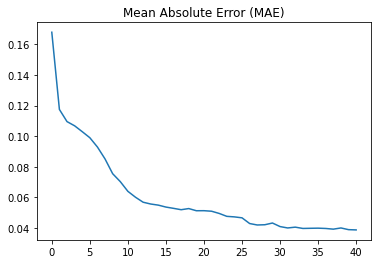

In [17]:
model_history = hist.history
loss = model_history['loss']
print(loss)



plt.figure()
plt.plot(loss, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.show()

In [18]:
predictions = model.predict(x_test_seq)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test_seq)
mae = np.mean(np.abs(predictions-y_test_original), axis=0)
for i, feature in enumerate(output_features):
    print("MAE untuk fitur ", feature, " : ", round(mae[i],3))
    if i == 3:
        break

19/19 [==============================] - 2s 10ms/step
MAE untuk fitur  Tn  :  0.426
MAE untuk fitur  Tx  :  0.727
MAE untuk fitur  RH_avg  :  4.384
MAE untuk fitur  RR  :  1.45


In [19]:
threshold_mae_Tn = (df['Tn'].max() - df['Tn'].min()) * 10 / 100
print("threshold_mae_Tn : ", threshold_mae_Tn)

threshold_mae_Tx = (df['Tx'].max() - df['Tx'].min()) * 10 / 100
print("threshold_mae_Tx : ", threshold_mae_Tx)

threshold_mae_RH_avg = (df['RH_avg'].max() - df['RH_avg'].min()) * 10 / 100
print("threshold_mae_RH_avg : ", threshold_mae_RH_avg)

threshold_mae_RR = (df['RR'].max() - df['RR'].min()) * 10 / 100
print("threshold_mae_RR : ", threshold_mae_RR)

threshold_mae_Tn :  6.4
threshold_mae_Tx :  9.6
threshold_mae_RH_avg :  37.0
threshold_mae_RR :  15.0


<function matplotlib.pyplot.show(close=None, block=None)>

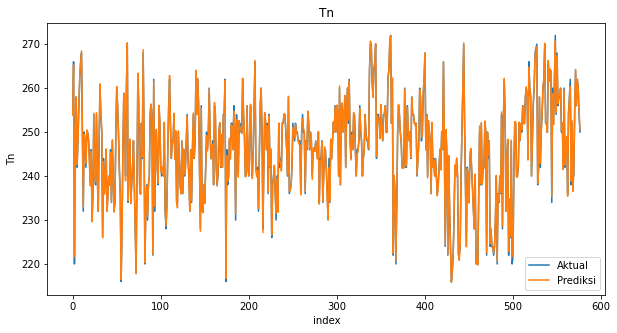

In [20]:
# Plot untuk Tn

target_index = 0 #Tn

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tn')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

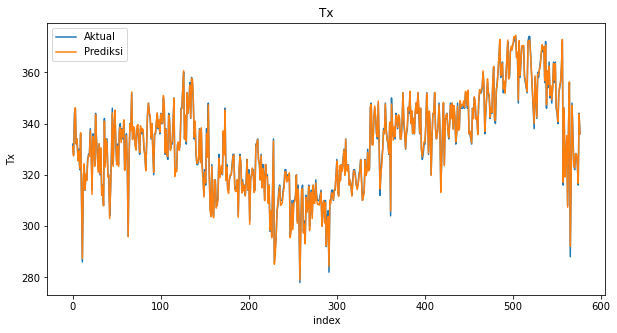

In [21]:
# Plot untuk Tx

target_index = 1 #Tx

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tx')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

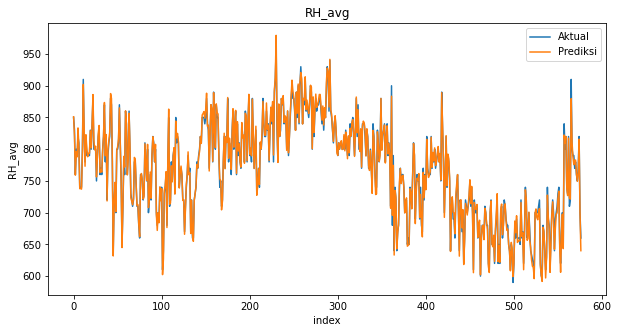

In [22]:
# Plot untuk RH_avg

target_index = 2 #RH_avg

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RH_avg')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

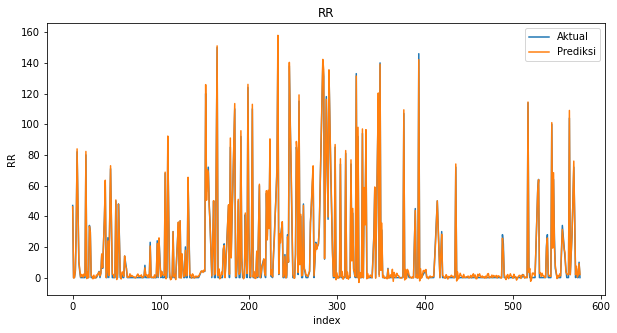

In [23]:
# Plot untuk RR

target_index = 3 #RR

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RR')
plt.legend()
plt.show

In [24]:
# Ambil 24 waktu terakhir dari data Anda
last_24_timesteps = df[input_features].values[-timesteps:]

# Normalisasi menggunakan scaler
last_24_timesteps_scaled = scaler.transform(last_24_timesteps)

# Inisialisasi array untuk menyimpan hasil prediksi
future_predictions = []

# Lakukan prediksi untuk 30 waktu ke depan
for _ in range(30):
    # Reshape untuk sesuai dengan input model
    input_sequence = last_24_timesteps_scaled.reshape(1, timesteps, n_features_input)
    
    # Prediksi satu waktu ke depan
    prediction = model.predict(input_sequence)
    
    # Invers transformasi scaler untuk mendapatkan nilai dalam skala asli
    prediction_inversed = scaler.inverse_transform(prediction)
    
    # Tambahkan prediksi ke dalam array hasil
    future_predictions.append(prediction_inversed.flatten())
    
    # Update sekuens input untuk waktu berikutnya
    last_24_timesteps_scaled = np.concatenate((last_24_timesteps_scaled[1:], prediction), axis=0)

# Konversi hasil prediksi ke dalam DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=output_features)

# Tampilkan hasil prediksi
print(future_predictions_df)

1/1 [==============================] - 0s 34ms/step
            Tn          Tx      RH_avg        RR   laju_Tn   laju_Tx  \
0   246.624176  328.730377  610.397339 -6.239623 -3.578532 -2.180044   
1   244.363892  333.804779  714.707275  0.018984 -1.066098  1.528299   
2   245.913406  334.060333  745.487427 -0.287437  1.175977  0.567749   
3   247.307785  336.014679  768.073120  2.052038 -0.682860  0.648515   
4   244.916382  335.378296  751.321777  1.251707 -0.777395 -0.268562   
5   245.739227  335.503906  739.280762 -0.326895  0.714733 -0.274725   
6   246.514450  335.224945  726.597107 -1.766574  0.343110 -0.644462   
7   246.843857  334.779510  733.986450 -2.296989 -0.099246 -0.834487   
8   246.927002  334.276978  741.874329 -2.210873 -0.285919 -0.635584   
9   246.859039  334.188232  749.339905 -2.025736 -0.393541 -0.470998   
10  246.639328  333.881897  751.201355 -2.036185 -0.280460 -0.437017   
11  246.729141  333.777618  751.213623 -2.241034 -0.051884 -0.326792   
12  246.9780

In [25]:
P_Tn = []
P_Tx = []
P_Tavg = []
P_RH_avg = []
P_RR = []
P_ss = []
for i in future_predictions_df['Tn']:
    P_Tn.append(round(np.abs(i),2))
for i in future_predictions_df['Tx']:
    P_Tx.append(round(np.abs(i),2))
for i in future_predictions_df['RH_avg']:
    P_RH_avg.append(round(np.abs(i),2))
for i in future_predictions_df['RR']:
    P_ss.append(round(np.abs(i),2))

In [26]:
print(P_Tn)

[246.62, 244.36, 245.91, 247.31, 244.92, 245.74, 246.51, 246.84, 246.93, 246.86, 246.64, 246.73, 246.98, 247.3, 247.52, 247.65, 247.72, 247.8, 247.91, 248.04, 248.16, 248.27, 248.36, 248.43, 248.51, 248.58, 248.65, 248.71, 248.77, 248.82]


In [28]:
model.save("model_weather_4hari_semarang.h5")